<h2>Loading a pre-trained YOLOv5-S instance for fine-tuning/inferencing on our Solar Panel dataset</h2>

In [1]:
!git clone https://github.com/ultralytics/yolov5  
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 17372, done.
remote: Counting objects: 100% (59/59), done.
remote: Compressing objects: 100% (39/39), done.
remote: Total 17372 (delta 42), reused 20 (delta 20), pack-reused 17313 (from 3)
Receiving objects: 100% (17372/17372), 16.26 MiB | 27.07 MiB/s, done.
Resolving deltas: 100% (11907/11907), done.
/kaggle/working/yolov5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 74.7 MB/s eta

<h3>Setting up the images and labels in correct directory structure</h3>

In [2]:
import os
import shutil
import cv2
import numpy as np
from tqdm import tqdm

base_dir = "/kaggle/input/solardata/DL Dataset/PV01"
output_images_dir = "/kaggle/working/images_raw"
output_masks_dir = "/kaggle/working/masks_raw"
os.makedirs(output_images_dir, exist_ok=True)
os.makedirs(output_masks_dir, exist_ok=True)

all_bmps = []

for folder in ["PV01_Rooftop_Brick", "PV01_Rooftop_FlatConcrete", "PV01_Rooftop_SteelTile"]:
    folder_path = os.path.join(base_dir, folder)
    bmp_files = sorted([f for f in os.listdir(folder_path) if f.endswith('.bmp')])
    for f in bmp_files:
        all_bmps.append(os.path.join(folder_path, f))

for idx, path in enumerate(all_bmps):
    filename = f"img_{idx//2:04d}.bmp"
    if idx % 2 == 0:
        shutil.copy(path, os.path.join(output_images_dir, filename))
    else:
        shutil.copy(path, os.path.join(output_masks_dir, filename))


<h3>Visualising 2 images and their corresponding labels to confirm correction of order</h3>

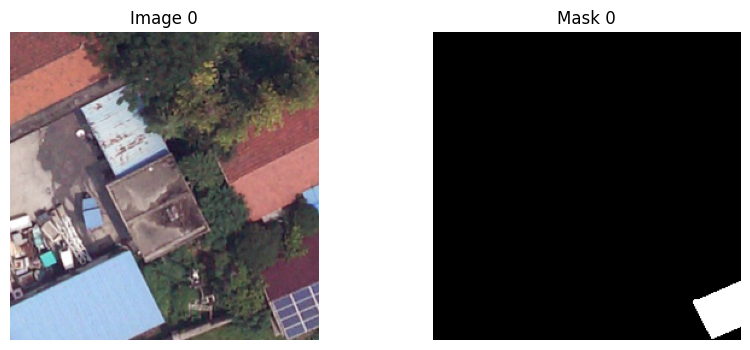

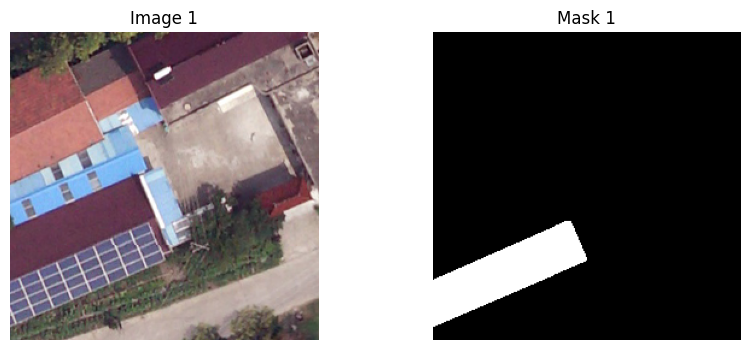

In [3]:
import matplotlib.pyplot as plt

def show_image_and_mask(index):
    image_path = os.path.join(output_images_dir, f"img_{index:04d}.bmp")
    mask_path = os.path.join(output_masks_dir, f"img_{index:04d}.bmp")

    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.imshow(image_rgb)
    plt.title(f"Image {index}")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title(f"Mask {index}")
    plt.axis("off")

    plt.show()

show_image_and_mask(0)
show_image_and_mask(1)


<h3>Producing YOLO style annotations for the solar panel images for object detection</h3>

In [4]:
label_output_dir = "/kaggle/working/labels"
os.makedirs(label_output_dir, exist_ok=True)

for filename in tqdm(sorted(os.listdir(output_masks_dir))):
    if not filename.endswith(".bmp"):
        continue

    mask_path = os.path.join(output_masks_dir, filename)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    h, w = mask.shape

    _, binary = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    label_lines = []

    for cnt in contours:
        x, y, bw, bh = cv2.boundingRect(cnt)

        if bw < 5 or bh < 5:
            continue

        x_center = (x + bw / 2) / w
        y_center = (y + bh / 2) / h
        norm_w = bw / w
        norm_h = bh / h

        label_lines.append(f"0 {x_center:.6f} {y_center:.6f} {norm_w:.6f} {norm_h:.6f}")

    label_filename = filename.replace(".bmp", ".txt")
    with open(os.path.join(label_output_dir, label_filename), "w") as f:
        f.write("\n".join(label_lines))


100%|██████████| 645/645 [00:00<00:00, 2602.05it/s]


<h3>Drawing the YOLO annotations/bounding boxes on top of the images</h3>

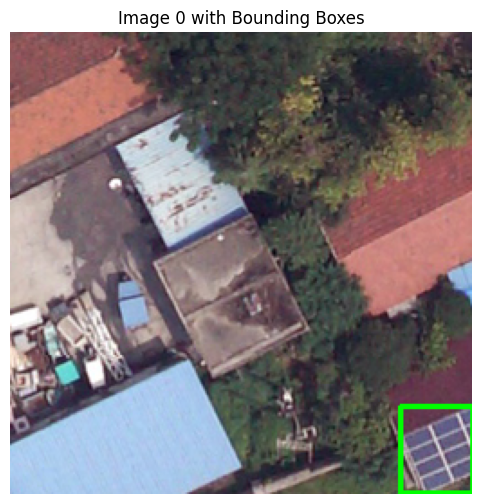

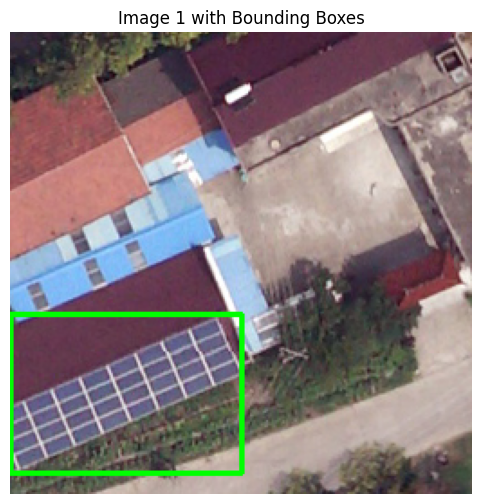

In [5]:
def draw_yolo_boxes(image_dir, label_dir, index):
    img_path = os.path.join(image_dir, f"img_{index:04d}.bmp")
    label_path = os.path.join(label_dir, f"img_{index:04d}.txt")

    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            lines = f.readlines()
            for line in lines:
                parts = line.strip().split()
                if len(parts) != 5:
                    continue
                cls, x_center, y_center, box_w, box_h = map(float, parts)
                # Convert from normalized to pixel values
                x_center *= w
                y_center *= h
                box_w *= w
                box_h *= h

                x1 = int(x_center - box_w / 2)
                y1 = int(y_center - box_h / 2)
                x2 = int(x_center + box_w / 2)
                y2 = int(y_center + box_h / 2)

                cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 2)

    plt.figure(figsize=(6, 6))
    plt.imshow(img_rgb)
    plt.title(f"Image {index} with Bounding Boxes")
    plt.axis("off")
    plt.show()

draw_yolo_boxes(output_images_dir, label_output_dir, 0)
draw_yolo_boxes(output_images_dir, label_output_dir, 1)


<h3>Setting up training files for YOLOv5</h3>

In [6]:
import os
import shutil
import random

yolo_dataset_dir = "/kaggle/working/solar_yolo"
images_raw_dir = "/kaggle/working/images_raw"
labels_raw_dir = "/kaggle/working/labels"

os.makedirs(f"{yolo_dataset_dir}/images/train", exist_ok=True)
os.makedirs(f"{yolo_dataset_dir}/images/val", exist_ok=True)
os.makedirs(f"{yolo_dataset_dir}/labels/train", exist_ok=True)
os.makedirs(f"{yolo_dataset_dir}/labels/val", exist_ok=True)

image_files = os.listdir(images_raw_dir)

val_count = int(len(image_files) * random.uniform(0.1, 0.15)) 
val_files = random.sample(image_files, val_count)

for f in image_files:
    image_file = f
    label_file = f.replace('.bmp', '.txt')  

    if f in val_files:
        shutil.copy(f"{images_raw_dir}/{image_file}", f"{yolo_dataset_dir}/images/val/{image_file}")
        shutil.copy(f"{labels_raw_dir}/{label_file}", f"{yolo_dataset_dir}/labels/val/{label_file}")
    else:
        shutil.copy(f"{images_raw_dir}/{image_file}", f"{yolo_dataset_dir}/images/train/{image_file}")
        shutil.copy(f"{labels_raw_dir}/{label_file}", f"{yolo_dataset_dir}/labels/train/{label_file}")


In [7]:
data_yaml = """
path: /kaggle/working/solar_yolo
train: images/train
val: images/val

nc: 1
names: ['solar_panel']
"""

with open("/kaggle/working/data.yaml", "w") as f:
    f.write(data_yaml)


<h3>Initialising training/fine-tuning on our dataset</h3>

In [8]:
!python train.py --img 640 --batch 16 --epochs 10 --data /kaggle/working/data.yaml --weights yolov5s.pt --name solar_detect --cache

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
wandb: WARNING ⚠️ wandb is deprecated and will be removed in a future release. See supported integrations at https://github.com/ultralytics/yolov5#integrations.
2025-04-14 19:53:09.726132: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744660390.187199     100 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744660390.307974     100 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS wh

<h3>Running validation</h3>

In [9]:
!python val.py --img 640 --batch 16 --data /kaggle/working/data.yaml --weights runs/train/solar_detect/weights/best.pt --task val --name solar_detect_val

val: data=/kaggle/working/data.yaml, weights=['runs/train/solar_detect/weights/best.pt'], batch_size=16, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=solar_detect_val, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
val: Scanning /kaggle/working/solar_yolo/labels/val.cache... 77 images, 3 backgr
                 Class     Images  Instances          P          R      mAP50   
                   all         77        597      0.881      0.916      0.925      0.676
Speed: 0.7ms pre-process, 10.5ms inference, 13.3ms NMS per image at shape (16, 3, 640, 640)
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid

<h3>Training Metrics Visualisations</h3>

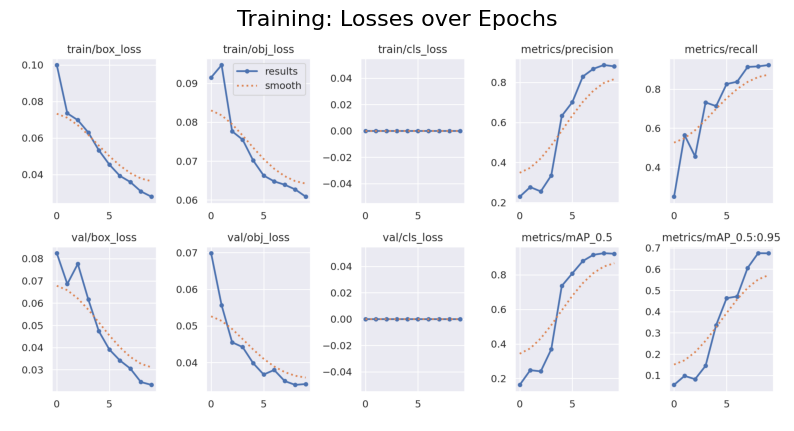

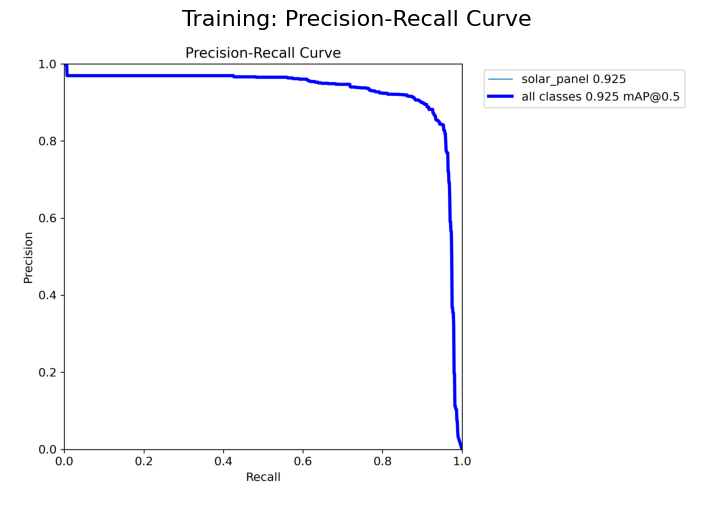

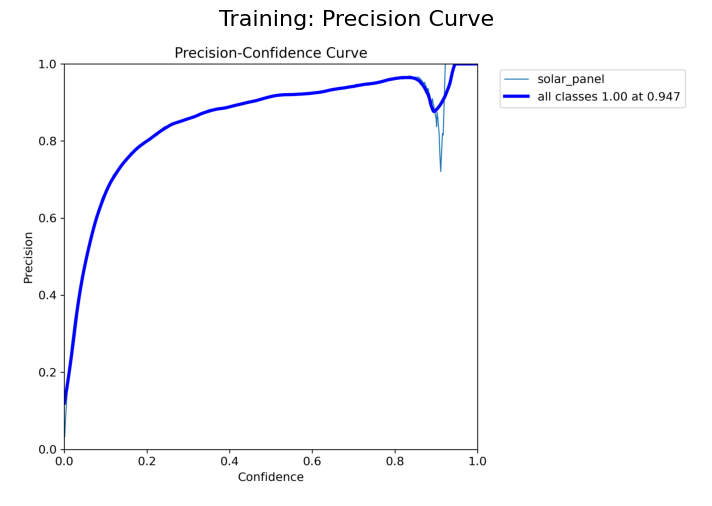

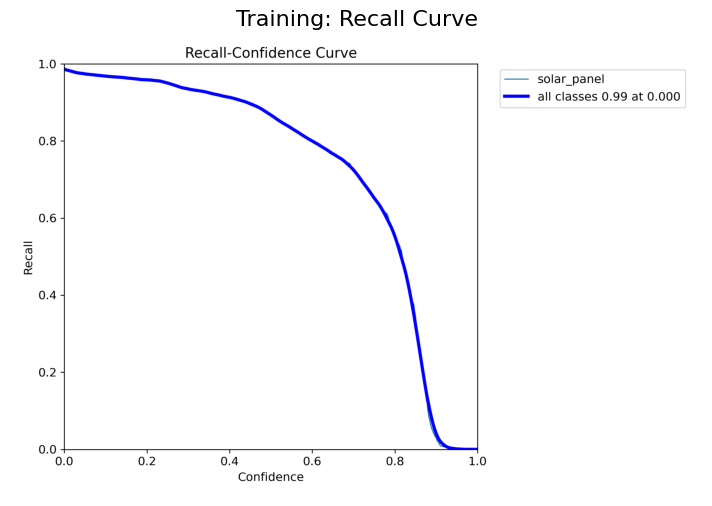

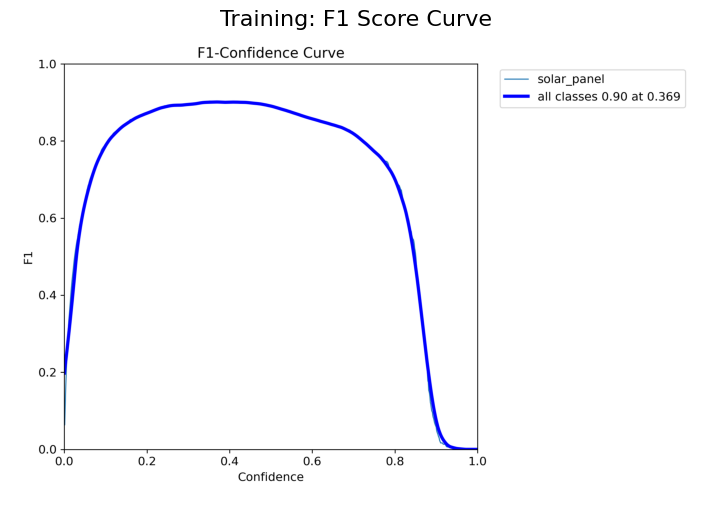

In [38]:
import matplotlib.pyplot as plt
from PIL import Image

train_dir = 'runs/train/solar_detect'
train_files = {
    'Training: Losses over Epochs': f'{train_dir}/results.png',
    'Training: Precision-Recall Curve': f'{train_dir}/PR_curve.png',
    'Training: Precision Curve': f'{train_dir}/P_curve.png',
    'Training: Recall Curve': f'{train_dir}/R_curve.png',
    'Training: F1 Score Curve': f'{train_dir}/F1_curve.png',
}

for title, path in train_files.items():
    img = Image.open(path)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()


<h3>Validation Set Metrics Visualisation</h3>

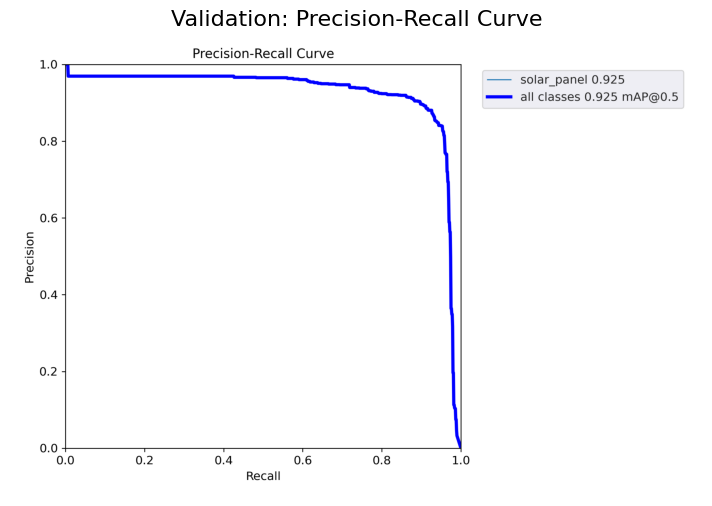

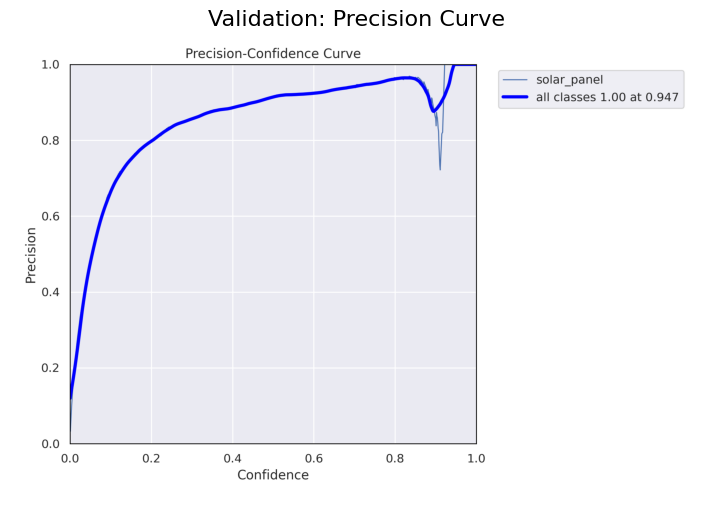

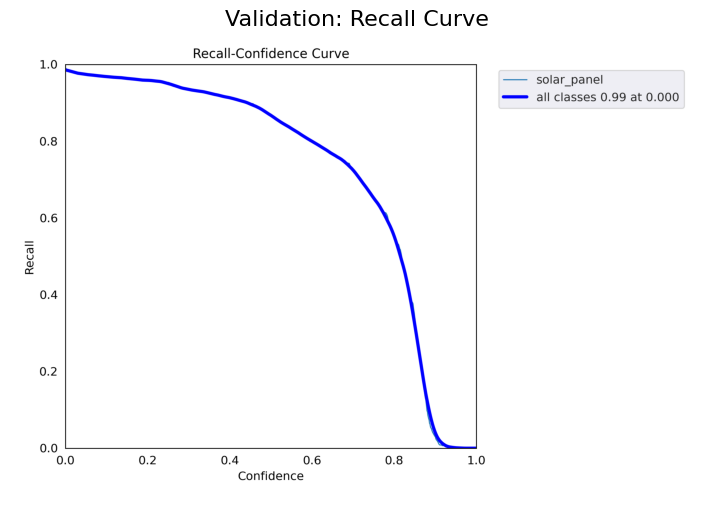

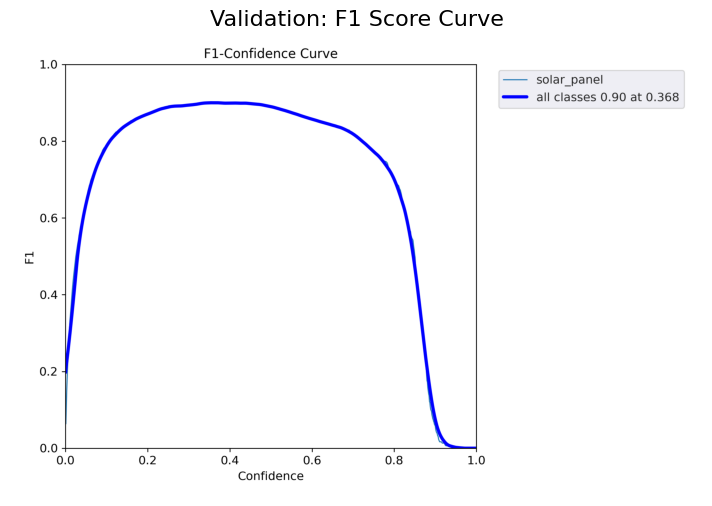

In [39]:
import matplotlib.pyplot as plt
from PIL import Image

val_dir = 'runs/val/solar_detect_val'
val_files = {
    'Validation: Precision-Recall Curve': f'{val_dir}/PR_curve.png',
    'Validation: Precision Curve': f'{val_dir}/P_curve.png',
    'Validation: Recall Curve': f'{val_dir}/R_curve.png',
    'Validation: F1 Score Curve': f'{val_dir}/F1_curve.png',
}

for title, path in val_files.items():
    img = Image.open(path)
    plt.figure(figsize=(10, 6))
    plt.imshow(img)
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()


In [21]:
import os
import random
import shutil

val_images_dir = '/kaggle/working/solar_yolo/images/val'
val_labels_dir = '/kaggle/working/solar_yolo/labels/val'
test_images_dir = '/kaggle/working/solar_yolo/test/images'
test_labels_dir = '/kaggle/working/solar_yolo/test/labels'

os.makedirs(test_images_dir, exist_ok=True)
os.makedirs(test_labels_dir, exist_ok=True)

val_images = os.listdir(val_images_dir)

random_images = random.sample(val_images, 5)

for image_name in random_images:
    label_name = image_name.replace('.bmp', '.txt')
    
    shutil.copy(os.path.join(val_images_dir, image_name), os.path.join(test_images_dir, image_name))
    shutil.copy(os.path.join(val_labels_dir, label_name), os.path.join(test_labels_dir, label_name))

os.listdir(test_images_dir), os.listdir(test_labels_dir)


(['img_0297.bmp',
  'img_0493.bmp',
  'img_0512.bmp',
  'img_0447.bmp',
  'img_0390.bmp',
  'img_0184.bmp'],
 ['img_0184.txt',
  'img_0512.txt',
  'img_0390.txt',
  'img_0493.txt',
  'img_0447.txt'])

<h3>Running Test Inferences</h3>

In [30]:
!python /kaggle/working/yolov5/detect.py --weights /kaggle/working/yolov5/runs/train/solar_detect/weights/best.pt --img 640 --source /kaggle/working/solar_yolo/test/images --save-txt

detect: weights=['/kaggle/working/yolov5/runs/train/solar_detect/weights/best.pt'], source=/kaggle/working/solar_yolo/test/images, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-411-gf4d8a84c Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)

Fusing layers... 
Model summary: 157 layers, 7012822 parameters, 0 gradients, 15.8 GFLOPs
image 1/5 /kaggle/working/solar_yolo/test/images/img_0184.bmp: 640x640 4 solar_panels, 11.4ms
image 2/5 /kaggle/working/solar_yolo/test/images/img_0390.bmp: 640x640 11 solar_panels, 11.5ms
image 3/5 /kaggle/working/solar_yolo/test/images/img_0447.bmp: 640x640 7 so

<h3>Visualising Test Predictions</h3>

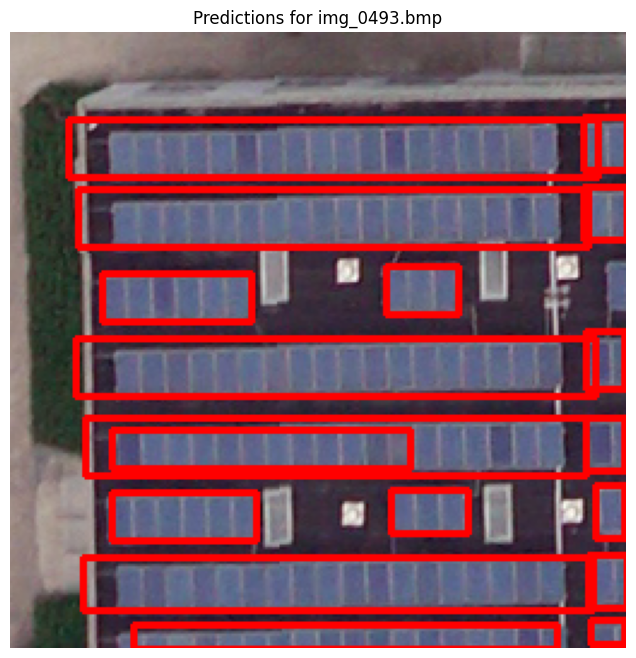

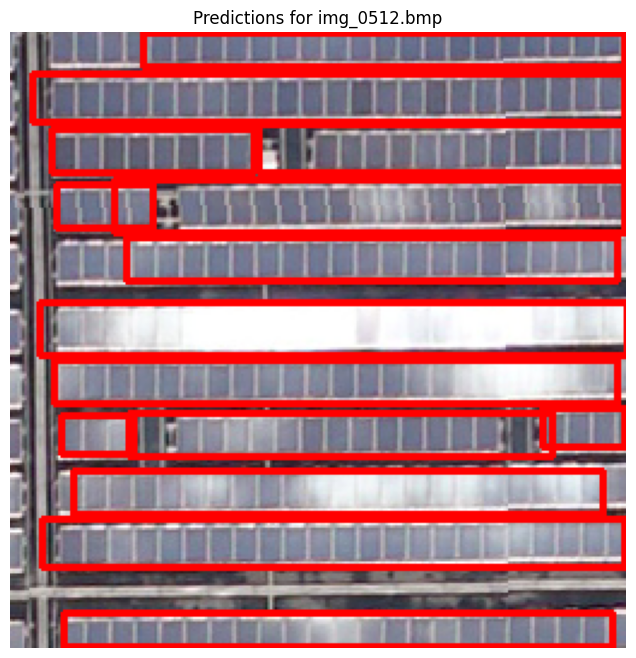

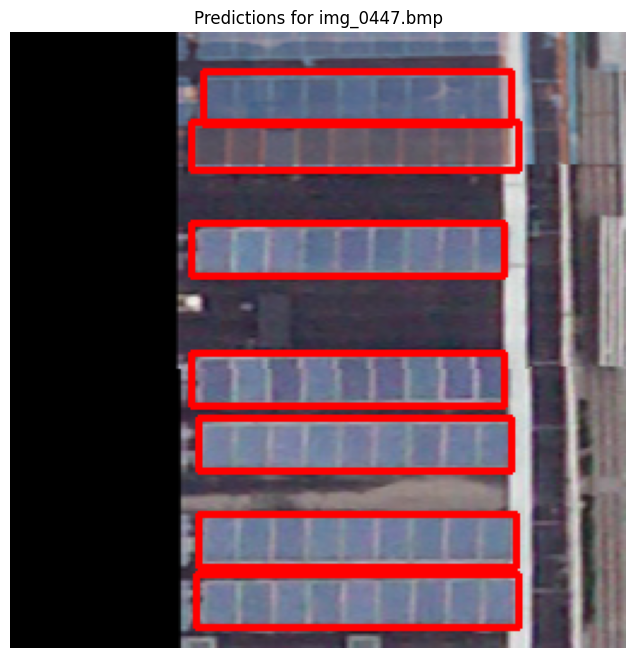

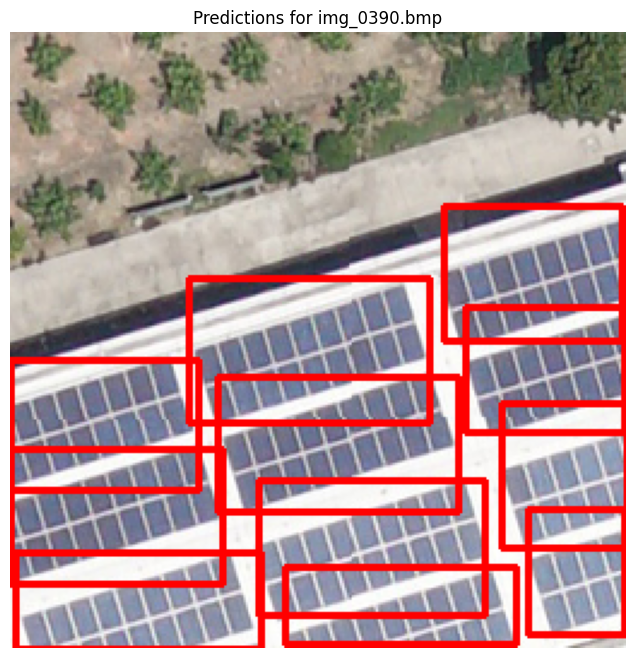

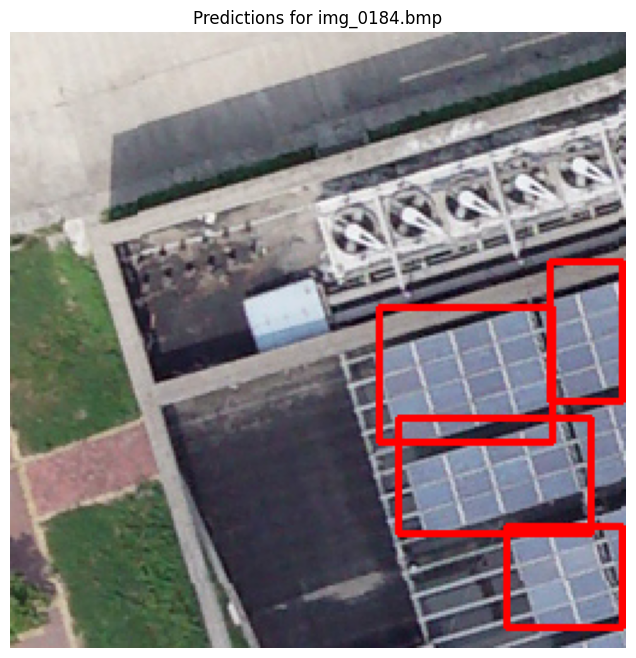

In [36]:
import os
import cv2
import matplotlib.pyplot as plt

image_dir = '/kaggle/working/solar_yolo/test/images'
label_dir = '/kaggle/working/yolov5/runs/detect/exp3/labels'

image_files = [f for f in os.listdir(image_dir) if f.endswith('.bmp')]

for image_file in image_files:
    image_path = os.path.join(image_dir, image_file)
    label_file = os.path.splitext(image_file)[0] + '.txt'  
    label_path = os.path.join(label_dir, label_file)
    
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) 
    
    if os.path.exists(label_path):
        with open(label_path, 'r') as f:
            lines = f.readlines()
        
        for line in lines:
            parts = line.strip().split()
            class_id = int(parts[0]) 
            x_center, y_center, width, height = map(float, parts[1:])
            
            h, w, _ = image.shape
            x_center, y_center, width, height = int(x_center * w), int(y_center * h), int(width * w), int(height * h)
            
            x1 = x_center - width // 2
            y1 = y_center - height // 2
            x2 = x_center + width // 2
            y2 = y_center + height // 2
            
            cv2.rectangle(image, (x1, y1), (x2, y2), (255, 0, 0), 2)
    
    plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.title(f"Predictions for {image_file}")
    plt.axis('off')
    plt.show()
